In [19]:
from bokeh.plotting import output_notebook, figure, show
output_notebook()

ModuleNotFoundError: No module named 'bokeh'

In [2]:
import numpy as np

In [3]:
import sympy as sp

Next, import some shortcuts:
- `S` turns the argument into a SymPy object. For example, `S("1/3")` evaluates to `1/3` *exactly*, avoiding issues related to Python's meaning of `/`.
- `Eq` creates an equation, but here I abuse it to print definitions of some variables.

In [4]:
from sympy import S, Eq

Now initialize printing to get pretty formulas in this notebook:

In [5]:
sp.init_printing()

Define variables

Note that $C_0$, etc are defined as SymPy variables to make it easier to inspect formulas defining $H$ and $u$ below (this hides unimportant details).

I'm working on the domain $x \in [0, R_0]$, $z \in [0, h(x)]$, so I assume that all these variables are positive. This allows SymPy to simplify some expressions involving powers.

In [6]:
sp.var("x y z sigma B R_0 H_0 t_0 t s rho_i g C_0 C_1 C_2", positive=True)
h = sp.Function("h")(x)

Here I define a few constants in a dictionary. I can supply this dictionary in `expr.subs(...)` to perform substitutions below.

In [7]:
A = 3.1689e-24
constants = {H_0 : 1000, # ice thickness at the center at t_0
             R_0: 750e3, # radius at t_0
             s: 1,       # (t / t_0)^(-1/11), s = 1 means use t_0
             g: 9.81,    # acceleration due to gravity
             rho_i: 910, # ice density
             B: A**(-1.0/3.0)} # ice hardness
constants

Next, I define `s0` to hide its details and because I'm not interested in time dependence.

In [8]:
s0 = (t / t_0)**S("-1/11")
c_0 = H_0 * s
Eq(C_0, c_0)

In [14]:
c_1 = s / R_0
Eq(C_1, c_1)

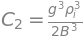

In [15]:
c_2 = 2 * B**(-3) * (rho_i * g)**3 / 4
Eq(C_2, c_2)

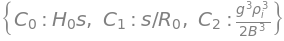

In [16]:
# Combine definitions to simplify substitutions
definitions = {C_0: c_0, C_1: c_1, C_2: c_2}
definitions

Now it's time to define the Halfar dome profile:

In [17]:
H = C_0 * (1 - (C_1 * x)**S("4/3"))**S("3/7")
Eq(h, H)

Sanity check:

In [18]:
xx = np.linspace(0, constants[R_0]-1, 1001)

HH = sp.lambdify(x, H.subs(definitions).subs(constants))

fig = figure(plot_width=750, plot_height=300, title="Halfar dome profile")
fig.line(xx, HH(xx), line_width=2)
show(fig)

NameError: name 'figure' is not defined

Now I can define the SIA velocity:

In [14]:
u = sp.Function("u")(x, z)
U = -C_2 * (h**4 - (h - z)**4) * h.diff(x)**3
Eq(u, U)

                                                 3
              ⎛             4    4   ⎞ ⎛d       ⎞ 
u(x, z) = -C₂⋅⎝- (-z + h(x))  + h (x)⎠⋅⎜──(h(x))⎟ 
                                       ⎝dx      ⎠ 

I prefer to define $u$ as a function of $x, \sigma$ because in these coordinates the domain is a rectangle and it's easy to work with.

In [15]:
u_s = sp.Function("u")(x, sigma)
U_s = U.subs(z, sigma * h).factor()
Eq(u_s, U_s)

                                                      3
                       ⎛ 2          ⎞  4    ⎛d       ⎞ 
u(x, σ) = C₂⋅σ⋅(σ - 2)⋅⎝σ  - 2⋅σ + 2⎠⋅h (x)⋅⎜──(h(x))⎟ 
                                            ⎝dx      ⎠ 

In my tests I saw that the B-P velocity "looks" linear in the *shallow* part of the domain, so I wanted to check if the SIA velocity is.

Here:

In [16]:
U_s.subs(h, H).doit()

      7   4                ⎛ 2          ⎞ 
-64⋅C₀ ⋅C₁ ⋅C₂⋅σ⋅x⋅(σ - 2)⋅⎝σ  - 2⋅σ + 2⎠ 
──────────────────────────────────────────
                   343                    

In [17]:
U_s_numpy = sp.lambdify([x, sigma], U_s.subs(h, H).subs(definitions).subs(constants).doit())

fig = figure(plot_width=750, plot_height=400,
             title="SIA velocity at levels of constant sigma")

xx = np.linspace(0, constants[R_0], 101)
for sig in np.linspace(0, 1, 11):
    fig.line(xx, U_s_numpy(xx, sig))
show(fig)

Define the Blatter-Pattyn system:

In [18]:
# velocity components
u = sp.Function("u")(x, y, z)
v = sp.Function("v")(x, y, z)

def div(f):
    "Divergence"
    return f[0].diff(x) + f[1].diff(y) + f[2].diff(z)

def grad(f):
    "Gradient"
    return sp.Matrix([f.diff(x), f.diff(y), f.diff(z)])

def second_invariant(u, v):
    """Second invariant of the strain rate tensor"""
    ux = u.diff(x)
    uy = u.diff(y)
    uz = u.diff(z)

    vx = v.diff(x)
    vy = v.diff(y)
    vz = v.diff(z)

    # In the BP approximation we assume that dw/dx << du/dz and dw/dy << dv/dz, so these
    # terms are omitted.
    wx = S(0)
    wy = S(0)

    return ux**2 + vy**2 + ux * vy + S(1) / 4 * ((uy + vx)**2 + (uz + wx)**2 + (vz + wy)**2)

def eta(u, v, n):
    "Ice viscosity"

    n = S(n)

    gamma = second_invariant(u, v)

    return S(1) / 2 * B * gamma**((1 - n) / (2 * n))

def M(u, v):
    "'Effective' strain rate tensor corresponding to the Blatter-Pattyn system"
    return sp.Matrix([[4 * u.diff(x) + 2 * v.diff(y), u.diff(y) + v.diff(x), u.diff(z)],
                      [u.diff(y) + v.diff(x), 2 * u.diff(x) + 4 * v.diff(y), v.diff(z)]])

def source_term(E, u, v):
    "Compute the source term required by a given 'exact' solution."
    # we assume that the system is written in this form:
    #
    # -div(eta*M) + f = 0
    #
    # where eta is ice viscosity and M is the effective strain rate tensor
    #
    # in the "regular" context
    #
    # f = rho * g * grad(s)

    f_u = div(E * M(u, v).row(0))
    f_v = div(E * M(u, v).row(1))

    return f_u, f_v

To compute the compensatory term,
define `V` which is a SymPy constant `0` and run the code above.

(SymPy would not know how to take a derivative of Python's `0`.)

In [19]:
V = S(0)
f = source_term(eta(U, V, 3), U, V)[0].subs(z, sigma * h)

Next (as a sanity check) I plot this compensatory term and the driving stress term.

The SIA is supposed to be a good approximation of the Stokes equations (and so the B-P equation) in areas of shallow deformational flow, so the compensatory term should be close to the term corresponding to the driving stress.

In [20]:
ff = sp.lambdify([x, sigma], f.subs(h, H).subs(definitions).doit().subs(constants))

# Create a NumPy function evaluating the driving stress term 
# from the B-P system (for comparison)
Tau_d = (rho_i * g * H.diff(x)).subs(definitions).subs(constants)
tau_d = sp.lambdify(x, Tau_d)

I avoid areas where SIA and B-P approximations differ by a lot ($x$ close to $0$ and $R_0$):

In [21]:
r = constants[R_0]
N = 1001
xx = np.linspace(0.01 * r, 0.99*r, N)

The plot below uses $\sigma$ in $[0, 0.5]$. For $\sigma$ in $(0.5, 1]$ the difference is much larger.

In [22]:
fig = figure(plot_width=750, plot_height=500,
             title="Driving stress vs. compensatory term in the bottom half of ice thickness")
for sig in np.linspace(0, 0.5, 11):
    fig.line(xx, ff(xx, sig))
fig.line(xx, tau_d(xx), line_color="red", legend_label="driving stress")
show(fig)

Same comparison, but looking at ratios:

In [23]:
T = tau_d(xx)
fig = figure(plot_width=750, plot_height=500,
             title="Ratio of the compensatory term and the driving stress")
for sig in np.linspace(0, 0.5, 11):
    fig.line(xx, ff(xx, sig) / T)
show(fig)

To generate C code, I use SymPy's "common sub-expression elimination" (CSE).

The `.doit()` call below forces evaluation of derivatives.

In [24]:
xs, F = sp.cse(f.subs(h, H).subs(definitions).subs(s, 1).doit())

This produces a number of intermediate expressions (`xs`) and the list of expressions equivalent to the one supplied (`F`).

Here the number of `xs` is quite large. We could reduce it by being clever about the form of the expression passed to `sp.cse` (hard-wiring constants would help, for example), but it does not seem to be worthwhile.

In [25]:
xs

⎡                                                                             
⎢⎛      1  ⎞  ⎛     4/3⎞                    ⎛         3/7⎞                    
⎢⎜x₀, ─────⎟, ⎝x₁, x   ⎠, (x₂, -x₀⋅x₁ + 1), ⎝x₃, H₀⋅x₂   ⎠, (x₄, -σ⋅x₃ + x₃), 
⎢⎜      4/3⎟                                                                  
⎣⎝    R₀   ⎠                                                                  

                                               ⎛     6   6⎞                   
⎛      6⎞  ⎛      6⎞  ⎛     1 ⎞  ⎛      1   ⎞  ⎜    g ⋅ρᵢ ⎟  ⎛      2         
⎝x₅, x₄ ⎠, ⎝x₆, H₀ ⎠, ⎜x₇, ───⎟, ⎜x₈, ──────⎟, ⎜x₉, ──────⎟, ⎝x₁₀, x ⋅x₆⋅x₇⋅x₈
                      ⎜      8⎟  ⎜      24/7⎟  ⎜       6  ⎟                   
                      ⎝    R₀ ⎠  ⎝    x₂    ⎠  ⎝      B   ⎠                   

                                                                              
   ⎞  ⎛       4⎞  ⎛              5/7⎞  ⎛     3 ___⎞  ⎛     16⋅x₁₃⎞  ⎛       3⎞
⋅x₉⎠, ⎝x₁₁, H₀ ⎠, ⎝x₁₂, x₀⋅x₁₁⋅x₂   ⎠, ⎝x₁₃, ╲╱ x 

The final expression looks pretty nasty, but it is not for human consumption, anyway.

In [26]:
F[0]

               ⎛8192⋅x₁₀⋅x₄₂       ⎛256⋅x₁₅⋅x₁₈⋅x₂₆⋅x₃₄   3072⋅x₁⋅x₁₁⋅x₂₅⋅x₃₉⎞
64⋅x₁₅⋅x₄₀⋅x₄₁⋅⎜──────────── - x₄₃⋅⎜─────────────────── - ───────────────────⎟
               ⎜   117649          ⎜        2401                  16/3   16/7⎟
               ⎝                   ⎝                       2401⋅R₀    ⋅x₂    ⎠
──────────────────────────────────────────────────────────────────────────────
                                      343                                     
                                                                              

⎞                                                                             
⎟                                                                             
⎟                                                                             
⎠   192⋅x₃₈⋅x₃₉⋅x₄₀           ⎛256⋅x₄₄   256⋅x₄₈   256⋅x₄₉   128⋅x₅₂⎞         
─ - ─────────────── + x₃₈⋅x₅₃⋅⎜─────── + ─────── + ─────── + ───────⎟ + x₄₁⋅x₅
          343                 ⎝ 50421     50421    

Now we're ready to generate the C code evaluating the compensatory term:

In [27]:
arguments = [x, sigma, H_0, R_0, rho_i, g, B]
args = ", ".join(["double " + str(variable) for variable in arguments])

print("double source_term({}) {{".format(args))
for v, expr in xs:
    print("  double " + sp.ccode(expr, assign_to=v))
print("  return {};".format(sp.ccode(F[0])))
print("}")

double source_term(double x, double sigma, double H_0, double R_0, double rho_i, double g, double B) {
  double x0 = pow(R_0, -4.0/3.0);
  double x1 = pow(x, 4.0/3.0);
  double x2 = -x0*x1 + 1;
  double x3 = H_0*pow(x2, 3.0/7.0);
  double x4 = -sigma*x3 + x3;
  double x5 = pow(x4, 6);
  double x6 = pow(H_0, 6);
  double x7 = pow(R_0, -8);
  double x8 = pow(x2, -24.0/7.0);
  double x9 = pow(g, 6)*pow(rho_i, 6)/pow(B, 6);
  double x10 = pow(x, 2)*x6*x7*x8*x9;
  double x11 = pow(H_0, 4);
  double x12 = x0*x11*pow(x2, 5.0/7.0);
  double x13 = cbrt(x);
  double x14 = (16.0/7.0)*x13;
  double x15 = pow(x4, 3);
  double x16 = H_0*x0*x15/pow(x2, 4.0/7.0);
  double x17 = -x12*x14 + x14*x16;
  double x18 = pow(R_0, -4);
  double x19 = x*x18;
  double x20 = pow(H_0, 3);
  double x21 = pow(x2, 12.0/7.0);
  double x22 = 1.0/x21;
  double x23 = pow(g, 3);
  double x24 = pow(rho_i, 3);
  double x25 = x23*x24/pow(B, 3);
  double x26 = x20*x22*x25;
  double x27 = x19*x26;
  double x28 = x17*x27;
  doub